In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from xgboost import XGBClassifier, plot_importance

In [2]:
#Import dataframe

df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Turn TotalCharges to numeric format

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isna().sum()



#Fill the missing values with the median of total charges

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())



#Convert Churn which is an object into binary integers (0/1)

if df['Churn'].dtype == 'object':
    df['Churn'] = (df['Churn'] == 'Yes').astype(int)



df['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [4]:
#Get rid of customerID because we won't need it to train our model

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [5]:
# Split features/target

X = df.drop(columns=['Churn']) #features
y = df['Churn'] #target

#Set up the parameters for testing/training

X_train, X_test, y_train, y_test  = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# we need to transform text entries into numbers and scale numerical values for later Logistic Regression



#extract categorical and numerical columns within the features

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64","float64"]).columns


#setup the feature preprocessor using ColumnTransformer to do everything in one go

preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


In [7]:
# This step sets up the classification pipeline and executes the training of the Logistic Regression model

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

#start training

clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
#Evaluate accuracy, ROC-AUC, recall and precision scores at a 0.5 threshold


y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

Accuracy: 0.8055358410220014
ROC-AUC: 0.8418739827946988
Recall: 0.5588235294117647
Precision: 0.6572327044025157


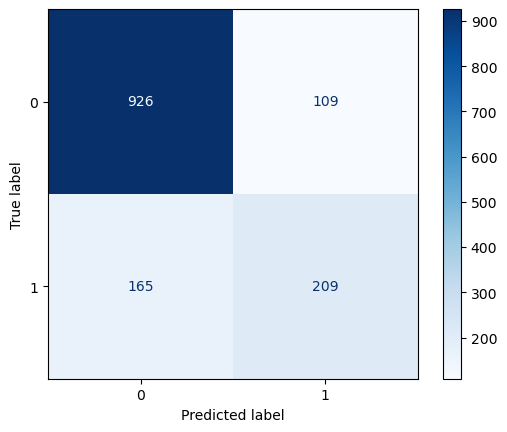

In [9]:
#Visualize the correct predictions and false predictions in a confusion matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues");

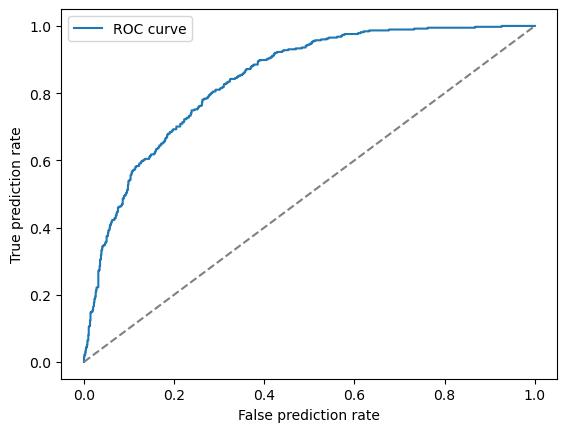

In [10]:
# a ROC curve would allow of a better visualisation of the tradeoff between sensitivity and false predictions

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0,1], [0,1], "--", color = "gray")
plt.xlabel("False prediction rate")
plt.ylabel("True prediction rate")
plt.legend()
plt.show();

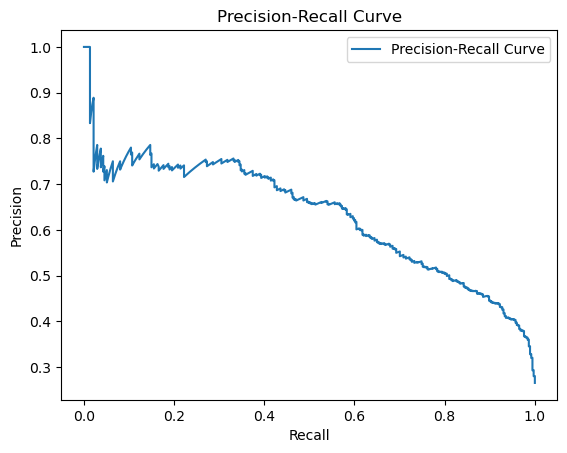

Observation: When recall becomes very high, precision drops dramatically.


In [11]:
# A precision-recall curve allows us to see and confirm how the precision drops when recall inceases - i.e. we get more false positives



prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

print("Observation: When recall becomes very high, precision drops dramatically.")

In [13]:
#A new attempt using a more powerful model (XGBoost) to see if recall can be improved at the same threshold.

xgb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]


print('Accuracy:', accuracy_score(y_test,y_pred_xgb))
print('ROC_AUC:', roc_auc_score(y_test,y_proba_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))


print("\nObservation: Using the current parameters, XGBoost is actually underperforming compared to Logistic Regression."
    " Let's try finetuning it.")

/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:15:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7849538679914834
ROC_AUC: 0.825448862021752
Recall: 0.5427807486631016
Precision: 0.6059701492537314

Observation: Using the current parameters, XGBoost is actually underperforming compared to Logistic Regression. Let's try finetuning it.


In [14]:
#This cell allows me to finetune the model's hyperparameters to (hopefully) get better results than Logistic Regression.


param_grid = {
    "model__max_depth":[3,7,9],
    "model__learning_rate":[0.05,.1,0.2],
    "model__n_estimators":[20,25,50,100,200],
    "model__subsample":[0.6,0.7,0.8,1.0] #randomly chosen
}

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=1
)

grid.fit(X_train,y_train)
best_model = grid.best_estimator_
y_proba_best = grid.predict_proba(X_test)[:,1]


print("Best parameters:", grid.best_params_)
print("Best ROC_AUC:", grid.best_score_)



Fitting 3 folds for each of 180 candidates, totalling 540 fits


/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mehdi/

Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.7}
Best ROC_AUC: 0.8514687348987753


/home/mehdi/anaconda3/envs/churn/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:17:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
#Threshold tuning for XGBoost using the best parameters that I found.


thresholds = np.arange(0.1,0.9,0.1)

for t in thresholds:
    preds = (y_proba_best >= t).astype(int)
    r = recall_score(y_test,preds)
    p = precision_score(y_test,preds)
    print(f"Threshold {t:.1f}: Recall={r:.3f}, Precision={p:.3f}")


print("\nObservation: Using XGBoost, it seems that the best threshold for optimal recall and precision is 0.3.")

Threshold 0.1: Recall=0.952, Precision=0.399
Threshold 0.2: Recall=0.845, Precision=0.475
Threshold 0.3: Recall=0.786, Precision=0.536
Threshold 0.4: Recall=0.647, Precision=0.595
Threshold 0.5: Recall=0.524, Precision=0.674
Threshold 0.6: Recall=0.348, Precision=0.743
Threshold 0.7: Recall=0.214, Precision=0.762
Threshold 0.8: Recall=0.083, Precision=0.838

Observation: Using XGBoost, it seems that the best threshold for optimal recall and precision is 0.3.


In [16]:
#Threshold tuning for Logistic Regression to compare it with XGBoost.

thresholds = np.arange(0.1,0.9,0.1)

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    r = recall_score(y_test,preds)
    p = precision_score(y_test,preds)
    print(f"Threshold {t:.1f}: Recall={r:.3f}, Precision={p:.3f}")


print("\nObservation: It seems that the best threshold for optimal recall and precision is also 0.3, SAME AS XGBoost.")

print("\nPossible conclusion: Using the parameters that I found, it looks like XGBoost isn't much better than logical regression "
     "at predicting churn.")

print("\nAdvice: Use logical regression because it's lighter and easier to interpret.")

Threshold 0.1: Recall=0.947, Precision=0.405
Threshold 0.2: Recall=0.856, Precision=0.467
Threshold 0.3: Recall=0.754, Precision=0.519
Threshold 0.4: Recall=0.668, Precision=0.569
Threshold 0.5: Recall=0.559, Precision=0.657
Threshold 0.6: Recall=0.401, Precision=0.718
Threshold 0.7: Recall=0.182, Precision=0.739
Threshold 0.8: Recall=0.027, Precision=0.769

Observation: It seems that the best threshold for optimal recall and precision is also 0.3, SAME AS XGBoost.

Possible conclusion: Using the parameters that I found, it looks like XGBoost isn't much better than logical regression at predicting churn.

Advice: Use logical regression because it's lighter and easier to interpret.


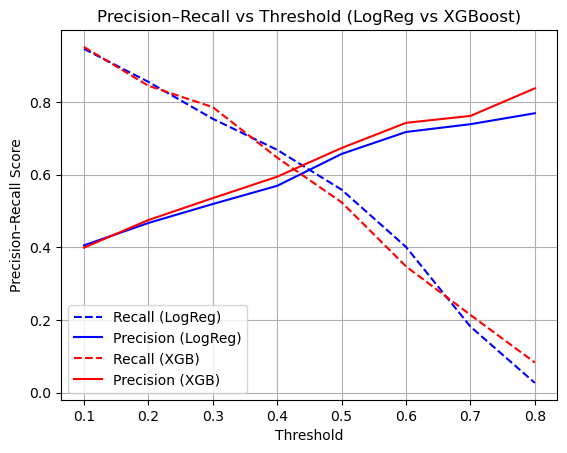

Observation: we can visually confirm that there isn't much of a difference between both models.


In [17]:
# visual comparison between the performance of both models as threshold increases.





# Logistic
recalls_lr, precisions_lr = [], []
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    recalls_lr.append(recall_score(y_test, preds))
    precisions_lr.append(precision_score(y_test, preds))

# XGBoost
recalls_xgb, precisions_xgb = [], []
for t in thresholds:
    preds = (y_proba_best >= t).astype(int)
    recalls_xgb.append(recall_score(y_test, preds))
    precisions_xgb.append(precision_score(y_test, preds))

plt.plot(thresholds, recalls_lr, 'b--', label='Recall (LogReg)')
plt.plot(thresholds, precisions_lr, 'b', label='Precision (LogReg)')
plt.plot(thresholds, recalls_xgb, 'r--', label='Recall (XGB)')
plt.plot(thresholds, precisions_xgb, 'r', label='Precision (XGB)')
plt.xlabel("Threshold")
plt.ylabel("Precision–Recall Score")
plt.title("Precision–Recall vs Threshold (LogReg vs XGBoost)")
plt.legend()
plt.grid(True)
plt.show()


print("Observation: we can visually confirm that there isn't much of a difference between both models.")

In [18]:
#feature impotance analysis for the logistic regression model


# get the trained model weights (coefficients)

lr_model = clf.named_steps["model"]
coef = lr_model.coef_[0]

#get the newly-created one hot encoded feature names and combine them with the numerical features

ohe = clf.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, encoded_cat_names])


#combine everything in a dataframe

importance = pd.DataFrame({"Features":feature_names, "Coefficient":coef})
importance["AbsCoef"] = importance["Coefficient"].abs() #shows the most important features regardless of positive or negative influence
importance.sort_values("AbsCoef", ascending=False).head(15)

,Features,Coefficient,AbsCoef
1,tenure,-1.241015,1.241015
38,Contract_Two year,-0.773004,0.773004
15,InternetService_DSL,-0.652640,0.652640
16,InternetService_Fiber optic,0.640185,0.640185
2,MonthlyCharges,-0.596379,0.596379
36,Contract_Month-to-month,0.579853,0.579853
3,TotalCharges,0.516280,0.516280
39,PaperlessBilling_No,-0.343088,0.343088
25,DeviceProtection_No internet service,-0.301064,0.301064
17,InternetService_No,-0.301064,0.301064



According the lr model, paying for fiber optics is the number one driver for chrurning. Possibly for cost-related reasons.

----------------------------------------- 
Having shorter contracts also seems to encourage the customers to turn to other providers.

----------------------------------------- 
The cost of the service is the third strongest driver for churning.

----------------------------------------- 
As shown, the longer one is a customer, the more likely they are to stay, possibly for comfort and habit related reasons.

----------------------------------------- 
Having a longer contract also predicts a negative churning outcome. Probably because of the sense of commitment they evoke

----------------------------------------- 
Having a DSL contract, which is cheaper than fiber optics, also counter-predicts churning.


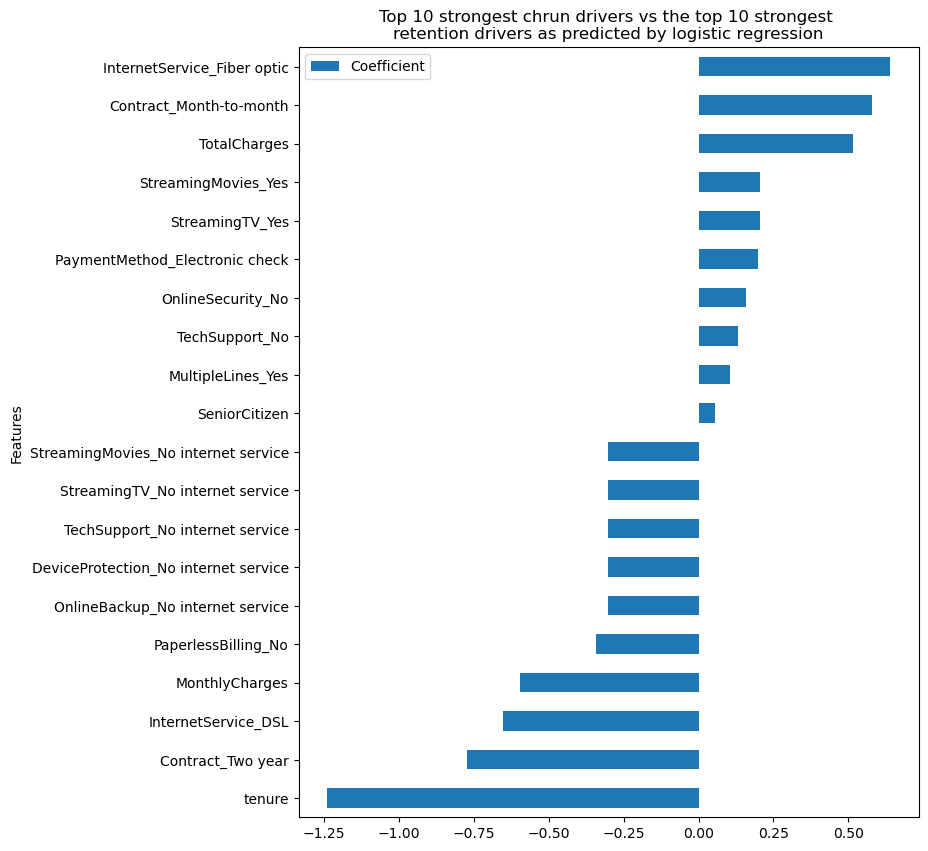

In [20]:
# visualizing the top 10 strongest chrun drivers vs the top 10 strongest retention drivers

top = importance.sort_values("Coefficient").tail(10) #top 10 drivers of churn
bottom = importance.sort_values("Coefficient").head(10) #top 10 retention drivers
top_ten_top_bottom = pd.concat([bottom,top])

top_ten_top_bottom.plot.barh(x="Features", y="Coefficient", figsize=(8,10))
plt.title("Top 10 strongest chrun drivers vs the top 10 strongest \nretention drivers as predicted by logistic regression")
plt.savefig("../outputs/figures/top_ten_lr.png", dpi=300, bbox_inches='tight');

print("\nAccording the lr model, paying for fiber optics is the number one driver for chrurning. Possibly for cost-related reasons.")

print("\n----------------------------------------- ")

print("Having shorter contracts also seems to encourage the customers to turn to other providers.")

print("\n----------------------------------------- ")

print("The cost of the service is the third strongest driver for churning.")

print("\n----------------------------------------- ")

print("As shown, the longer one is a customer, the more likely they are to stay, possibly for comfort and habit related reasons.")

print("\n----------------------------------------- ")

print("Having a longer contract also predicts a negative churning outcome. Probably because of the sense of commitment they evoke")

print("\n----------------------------------------- ")

print("Having a DSL contract, which is cheaper than fiber optics, also counter-predicts churning.")


According the GXB model, having a month to month contract is the number one driver for chrurning. Customers with short contracts tend to 
change providers more often than the ones with longer contracts.

----------------------------------------- 
According the GXB model, Fiber Optics subscribers tend to churn more often, possibly for cost-related reasons.

----------------------------------------- 


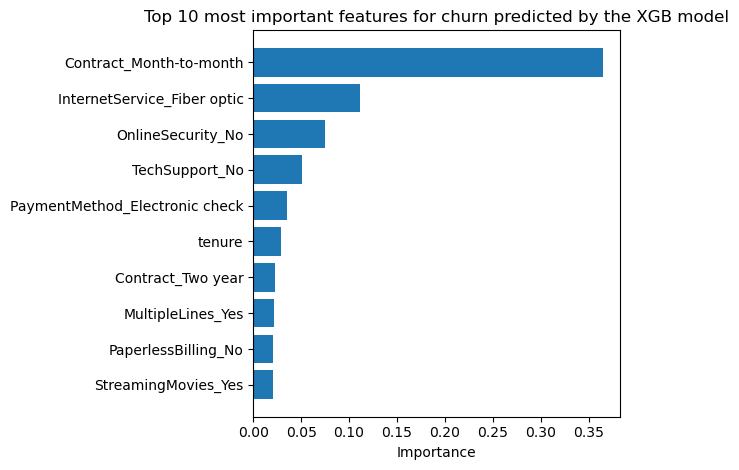

In [21]:
# For comparison, I decided to plot the top ten most important features for churn predicted by the XGB model.

# Grab the numerical and categorical features

num_features = num_cols
cat_features = best_model.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(cat_cols)

# Combine both feature variables into a single np array

all_features = np.concatenate([num_features, cat_features])

# Grab the importances of the features from the trained XGB model...

xgb = best_model.named_steps["model"]
importances = xgb.feature_importances_

# ...and put them together with their respective features in a single dataframe sorted by importance

feat_importance = pd.DataFrame({"Feature":all_features, 
                                "Importance":importances}).sort_values("Importance", ascending=False)

feat_importance.head(10)


# Time to plot

top = feat_importance.head(10)[::-1]

plt.barh(top["Feature"],top["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 most important features for churn predicted by the XGB model")
plt.tight_layout()
plt.savefig("../outputs/figures/top_ten_XGB.png", dpi=300, bbox_inches='tight');


print("\nAccording the GXB model, having a month to month contract is the number one driver for chrurning. "
      "Customers with short contracts tend to \nchange providers more often than the ones with longer contracts.")

print("\n----------------------------------------- ")

print("According the GXB model, Fiber Optics subscribers tend to churn more often, possibly for cost-related reasons.")

print("\n----------------------------------------- ")

In [22]:
# Finally, export both model predictions into a single CSV file


# Logistic Regression predictions
y_pred_lr = clf.predict(X_test)
y_proba_lr = clf.predict_proba(X_test)[:, 1]

results_lr = pd.DataFrame({
    "model": "LogisticRegression",
    "y_true": y_test,
    "y_pred": y_pred_lr,
    "y_proba": y_proba_lr
})

# XGBoost predictions
y_pred_xgb = best_model.predict(X_test)
y_proba_xgb = best_model.predict_proba(X_test)[:, 1]

results_xgb = pd.DataFrame({
    "model": "XGBoost",
    "y_true": y_test,
    "y_pred": y_pred_xgb,
    "y_proba": y_proba_xgb
})


# Combine and export to csv

results = pd.concat([results_lr, results_xgb])
results.to_csv("../outputs/model_results.csv", index=False)
print("Saved to outputs/model_results.csv")

Saved to outputs/model_results.csv


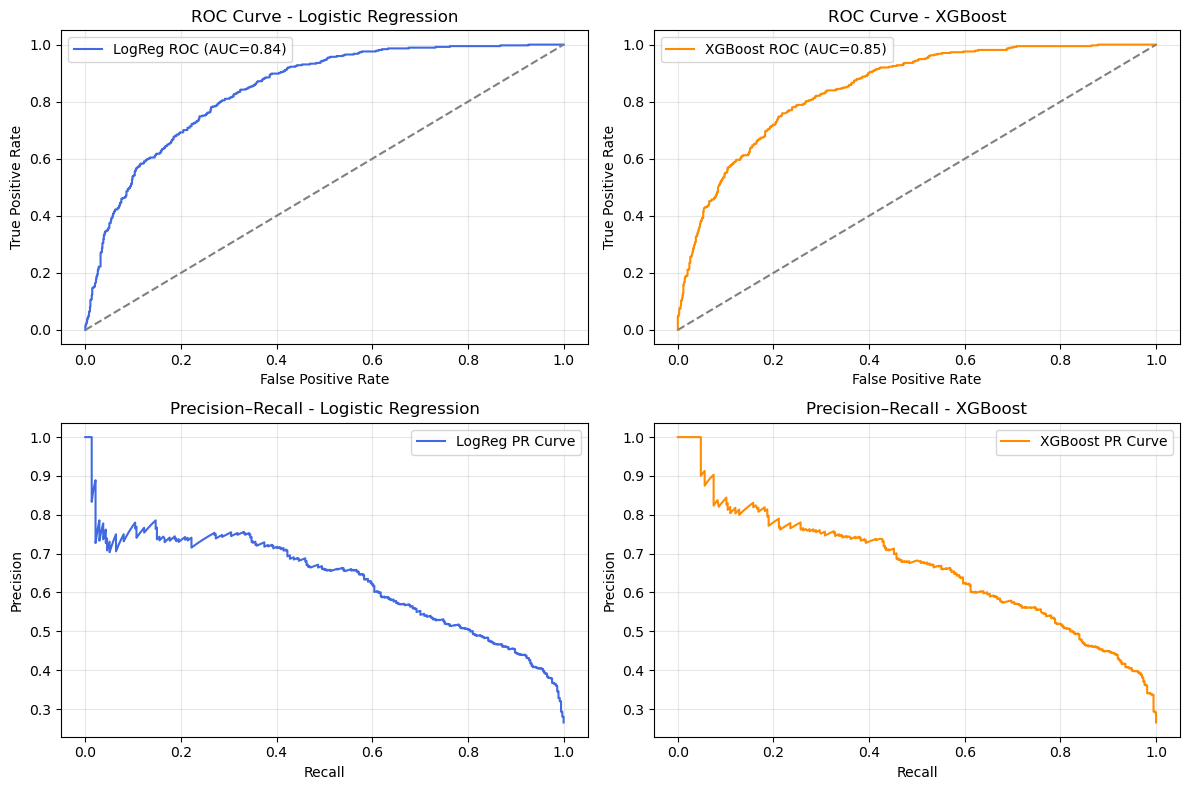

In [25]:
# plot and save relevant figures for model performance

# --- ROC + PR for Logistic Regression ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# --- ROC + PR for XGBoost ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_best)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_best)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# --- Create combined figure ---
plt.figure(figsize=(12, 8))

# ROC - Logistic Regression
plt.subplot(2, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg ROC (AUC={roc_auc_lr:.2f})", color="royalblue")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)

# ROC - XGBoost
plt.subplot(2, 2, 2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost ROC (AUC={roc_auc_xgb:.2f})", color="darkorange")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True, alpha=0.3)

# PR - Logistic Regression
plt.subplot(2, 2, 3)
plt.plot(rec_lr, prec_lr, label="LogReg PR Curve", color="royalblue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall - Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)

# PR - XGBoost
plt.subplot(2, 2, 4)
plt.plot(rec_xgb, prec_xgb, label="XGBoost PR Curve", color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall - XGBoost")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/figures/roc_pr_curves.png", dpi=300)
plt.show()
